<a href="https://colab.research.google.com/github/Donorone35/Stock-Price-Prediction/blob/main/Stock_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM


In [3]:
import yfinance as yf
import datetime as dt

company = 'META'

start = dt.datetime(2015, 1, 1)
end = dt.datetime(2024, 1, 1)

data = yf.download(company, start=start, end=end)

print(data.head())


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker           META       META       META       META      META
Date                                                            
2015-01-02  78.151459  78.629635  77.404313  78.280969  18177500
2015-01-05  76.896271  78.948429  76.567525  77.683265  26452200
2015-01-06  75.860214  77.294729  75.073220  76.936106  27399300
2015-01-07  75.860214  77.065609  75.531468  76.467893  22045300
2015-01-08  77.882492  77.932305  75.790485  76.447969  23961000


In [4]:
# Prepare Data
if 'Close' not in data.columns:
    raise ValueError("Error: 'Close' column not found in dataset.")

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 30

# Ensure there are enough data points
if len(scaled_data) <= prediction_days:
    raise ValueError("Error: Not enough data points for the given prediction_days.")

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0475
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0024
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0014
Epoch 16/50
70/7

[*********************100%***********************]  1 of 1 completed


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


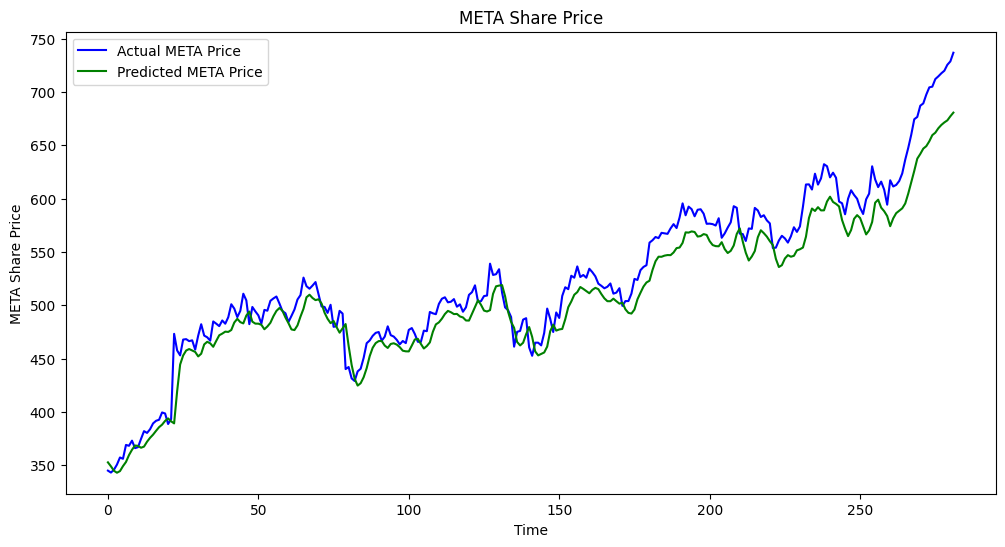

In [5]:
model = Sequential()

# Increase LSTM units and reduce dropout
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.1))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=100))
model.add(Dropout(0.1))

model.add(Dense(units=1))

# Use Adam optimizer
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='mean_squared_error')


model.fit(x_train, y_train, epochs=50, batch_size=32)

'''Test Model Accuracy on Existing Data'''


test_start = dt.datetime(2024, 1, 1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)

actual_prices = test_data['Close'].values


total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

prediction_days = 50

model_inputs = total_dataset.iloc[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict prices and inverse transform
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot Test Predictions
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, color="blue", label=f"Actual {company} Price")
plt.plot(predicted_prices, color='green', label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()


In [6]:
# Predict Next Day

real_data = model_inputs[-prediction_days:]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (1, real_data.shape[0], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

print(f"Prediction: {prediction[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: 686.325439453125
